### This should be the best [Scheduler](https://fastai.github.io/timmdocs/SGDR)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR

### CosineAnnealingLRRestart
Extend from Pytorch CosineAnnealingLR, added restart

In [5]:
from torch.optim.lr_scheduler import _LRScheduler, CosineAnnealingWarmRestarts
import torch
class CosineAnnealingLRRestart(_LRScheduler):
    def __init__(self, optimizer, T_max, eta_min=0, T_mul=1, last_epoch=-1, verbose=False):
        self.optimizer = optimizer
        self.T_max = T_max
        self.T_mul = T_mul
        self.eta_min = eta_min
        self.last_epoch = last_epoch
        self.verbose = verbose
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, 
               T_max=self.T_max, eta_min=self.eta_min, last_epoch=self.last_epoch, verbose=self.verbose)
        
        
    def get_lr(self):
        return self.scheduler.get_lr()
    
    def step(self, step=None):
        self.scheduler.step()
        if self.optimizer.param_groups[0]['lr'] <= self.eta_min:
            self.T_max *= self.T_mul
#             for param_group in optimizer.param_groups:
#                 param_group["initial_lr"] = param_group["initial_lr"] * 0.8
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, 
               T_max=self.T_max, eta_min=self.eta_min, last_epoch=self.last_epoch, verbose=self.verbose)

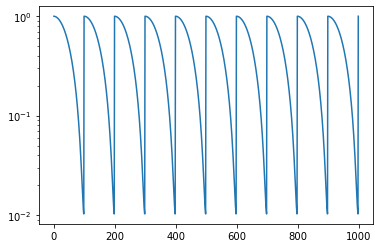

In [23]:
model = nn.Sequential(nn.Conv2d(1,20,5))
optimizer = torch.optim.Adam(model.parameters(), lr=1)

scheduler = CosineAnnealingLRRestart(optimizer, T_max=100, eta_min=.01, T_mul=1)
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=1)
lrs = []
for i in range(1000):
    optimizer.step()
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    lrs.append(lr)
   
plt.plot(lrs, '-')
plt.yscale('log')

### CosineAnnealingWarmRestarts

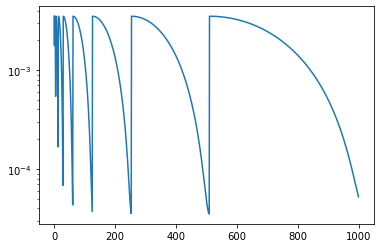

In [30]:
model = nn.Sequential(nn.Conv2d(1,20,5))
lr = 0.0035
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# scheduler = CosineAnnealingLRRestart(optimizer, T_max=100, eta_min=.01, T_mul=1)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=lr*0.01)
lrs = []
for i in range(1000):
    optimizer.step()
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    lrs.append(lr)
   
plt.plot(lrs, '-')
plt.yscale('log')

### PolynomialLRDecay [pytorch]

In [119]:
from torch.optim.lr_scheduler import _LRScheduler
class PolynomialLRDecay(_LRScheduler):
    """Polynomial learning rate decay until step reach to max_decay_step
    
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        max_decay_steps: after this step, we stop decreasing learning rate
        end_learning_rate: scheduler stoping learning rate decay, value of learning rate must be this value
        power: The power of the polynomial.
    """
    
    def __init__(self, optimizer, max_decay_steps, end_learning_rate=0.0001, power=1.0):
        if max_decay_steps <= 1.:
            raise ValueError('max_decay_steps should be greater than 1.')
        self.max_decay_steps = max_decay_steps
        self.end_learning_rate = end_learning_rate
        self.power = power
        self.last_step = 0
        super().__init__(optimizer)
        
    def get_lr(self):
        if self.last_step > self.max_decay_steps:
            return [self.end_learning_rate for _ in self.base_lrs]

        return [(base_lr - self.end_learning_rate) * 
                ((1 - self.last_step / self.max_decay_steps) ** (self.power)) + 
                self.end_learning_rate for base_lr in self.base_lrs]
    
    def step(self, step=None):
        if step is None:
            step = self.last_step + 1
        self.last_step = step if step != 0 else 1
        if self.last_step <= self.max_decay_steps:
            decay_lrs = [(base_lr - self.end_learning_rate) * 
                         ((1 - self.last_step / self.max_decay_steps) ** (self.power)) + 
                         self.end_learning_rate for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, decay_lrs):
                param_group['lr'] = lr

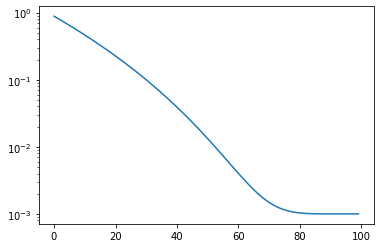

In [120]:
model = nn.Sequential(nn.Conv2d(1,20,5))
optimizer = torch.optim.Adam(model.parameters(), lr=1)

T_mul = 2
T_max = 10
eta_min = .5
scheduler = PolynomialLRDecay( optimizer, 100, 1e-3, power=6.0)
lrs = []
for i in range(100):
#     for param_group in optimizer.param_groups:
#         param_group["lr"] = param_group["lr"] * 0.3
    optimizer.step()
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    lrs.append(lr)
   
plt.plot(lrs, '-')
plt.yscale('log')

### Overwrite LR
overwrite all the scheduler

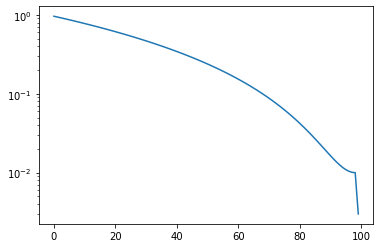

In [9]:
model = nn.Sequential(nn.Conv2d(1,20,5))
optimizer = torch.optim.Adam(model.parameters(), lr=1)

T_mul = 2
T_max = 10
eta_min = .5
scheduler = PolynomialLRDecay( optimizer, 100, 1e-2, power=2.0)
lrs = []
for i in range(100):
    for param_group in optimizer.param_groups:
        param_group["lr"] = param_group["lr"] * 0.3
    optimizer.step()
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    lrs.append(lr)
   
plt.plot(lrs, '-')
plt.yscale('log')

### TF

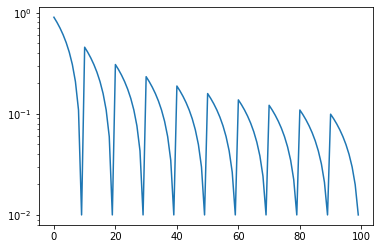

In [6]:
import tensorflow as tf
learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
        1.,
        decay_steps=10,
        end_learning_rate=1e-2,
        cycle=True)

model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(2,))])
x = tf.constant([[1, 2], [3, 4], [5, 6]])
lrs = []
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
for i in range(100):
    with tf.GradientTape() as tape:
        y = model(x)
        loss = tf.reduce_mean(y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        lr = optimizer._decayed_lr(tf.float32).numpy()
        lrs.append(lr)
plt.plot(lrs, '-')
plt.yscale('log')

In [ ]:
gradients = tape.gradient(total_loss, model.trainable_variables)
optimizer.apply_gradients(zip(gradients, model.trainable_variables))